In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import PIL
import tensorflow as tf
import cupy as cp

TPU = False

if TPU:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
  

import pathlib
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from sklearn.utils.extmath import randomized_svd

Found GPU at: /device:GPU:0
Fri Apr 29 07:16:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |    292MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [2]:
from google.colab import drive
drive.mount("/ShardDrives/", force_remount=True)
data_dir = "/ShardDrives/My Drive/CSE382M/Photos_Lite"
data_dir = pathlib.Path(data_dir)

Mounted at /ShardDrives/


In [3]:
color = False

batch_size = 32
img_height = 256
img_width = 256
img_channels = 1
color_mode = "grayscale"
if color:
  img_channels = 3
  color_mode = "rgb"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  color_mode=color_mode,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=None)

test_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  color_mode=color_mode,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=None)

X_test = []
Y_test = []

X_train = []
Y_train = []

X_val = []
Y_val = []

for i, tup in enumerate(test_val_ds):
  if i < len(test_val_ds)/2:
    X_test.append(tup[0].numpy())
    Y_test.append(tup[1].numpy())
  else:
    X_val.append(tup[0].numpy())
    Y_val.append(tup[1].numpy())

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)
print(X_test.shape, Y_test.shape, X_val.shape, Y_val.shape)

for tup in train_ds:
  X_train.append(tup[0].numpy())
  Y_train.append(tup[1].numpy())

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
print(X_train.shape, Y_train.shape)

Found 2800 files belonging to 4 classes.
Using 1680 files for training.
Found 2800 files belonging to 4 classes.
Using 1120 files for validation.
(560, 256, 256, 1) (560,) (560, 256, 256, 1) (560,)
(1680, 256, 256, 1) (1680,)


In [5]:
full_SVD_analysis = False
if full_SVD_analysis:
  init = time.time()
  # print(X_train[0].reshape(256,256).shape)
  # X_train_flat = X_train.reshape(-1,256*256)
  X_train_flat = X_train.reshape(-1,img_height*img_width)
  print(X_train_flat.shape)
  abc
  X_train_cov = np.cov(X_train_flat.T)
  print(X_train_cov.shape)
  abc
  # print(X_train_flat.shape)
  U, s, Vh = randomized_svd(X_train_cov, n_components=1680, random_state=1)
  print(time.time() - init)
  total_E = np.sum(s**2)
  p = [i**2/total_E for i in s]
  k = np.argwhere(np.cumsum(p) > .95)[0][0]
  print(k)

  ax = plt.axes()
  ax.semilogy(range(len(s)), s, marker='D') # TODO: Change to log scale # TODO: singular value histogram shaded plot for 50 reps for training data
  ax.plot(k,s[k],marker='D',markerfacecolor='#FFA500',)
  ax.hlines(s[k], 0, k, linestyle="dashed")
  ylim = ax.get_ylim()
  ax.vlines(k, ax.get_ylim()[0], s[k], linestyle="dashed")
  ax.set_xticks(list(ax.get_xticks()) + [k])
  ax.set(xlabel='Index of Singular Values', ylabel='Singular Values',
        title='Singular Value Decay',xlim=[0,len(p)],ylim=ylim);
  # plt.savefig('SValue_Decay_LF2.png', dpi=300)
init = time.time()
reduced_dim = 144

X_train_flat = X_train.reshape(-1,img_height*img_width)
X_val_flat = X_val.reshape(-1,img_height*img_width)
X_test_flat = X_test.reshape(-1,img_height*img_width)

pca = PCA(n_components=144, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train_flat)

X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)

X_val_pca = X_val_pca.reshape((-1,12,12,1))
X_test_pca = X_test_pca.reshape((-1,12,12,1))
X_train_pca = X_train_pca.reshape((-1,12,12,1))
# plt.imshow(X_train[100], cmap='gray')


img_height = 12
img_width = 12
print(X_train_pca.shape)
# # U,s,_ = randomized_svd((X_train_flat - np.mean(X_train_flat, axis=0)).T, n_components=reduced_dim, random_state=1)
# U_val, s_val = randomized_svd((X_train_flat - np.mean(X_train_flat, axis=0)).T, n_components=reduced_dim, random_state=1)
# # first_layer_weights = [U[:, :reduced_dim].T, np.mean(X_train_flat, axis=0)]
# X_train_flat = X_train_flat@U
# X_train = X_train_flat.reshape((-1,12,12,1))
# # X_train = np.expand_dims(X_train, axis=1)
# print(X_train.shape)
# img_height = 12
# img_width = 12
# # plt.imshow(X_train_flat[0], cmap='gray')
# # plt.show
print(time.time() - init)

(1680, 12, 12, 1)
10.968196392059326


In [6]:
# plt.imshow(X_train[100].reshape(256,256), cmap='gray')
# plt.show()
# sample = X_train_pca[100].reshape(-1,12*12)
# sample = pca.inverse_transform(sample)
# plt.imshow(sample.reshape(256,256), cmap='gray')
# plt.show()

In [7]:
# Model 1:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# Model 2:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        vertical_flip=True,
        rotation_range=15,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(X_train_pca, seed=1)
# model 3 = increased patience on callback early stopping

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
class_names = train_ds.class_names
print(class_names)

['baseball_diamond', 'basketball_court', 'lake', 'railway_station']


In [9]:
num_classes = len(class_names)
kreg = None #tf.keras.regularizers.l2(l=0.01)
# layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
model = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, img_channels)),

  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.BatchNormalization(),
  layers.Conv2D(32, 5, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.BatchNormalization(),
  # layers.Dropout(0.2),


  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.BatchNormalization(),
  layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=kreg),
  layers.MaxPool2D(),
  layers.BatchNormalization(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])
# TODO: 
# 2) increase network depth

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

In [11]:
def scheduler(epoch, lr):
  # return lr
  if (epoch+1) % 25 == 0:
    return float(lr * 0.5)
  else:
    return lr
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=30)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
epochs=500
batch_size = 16
history = model.fit(
  train_datagen.flow(X_train_pca, Y_train, batch_size=batch_size),
  validation_data=test_datagen.flow(X_val_pca, Y_val, 
                               batch_size=batch_size),
  epochs=epochs,
  callbacks=[es, mc, lrs]
)
# history = model.fit(
#   x=X_train,
#   y=Y_train,
#   batch_size=batch_size,
#   validation_split=0.2,
#   epochs=epochs,
#   callbacks=[es, mc, lrs]
# )
print(len(history.history['loss']))  

Epoch 1/500
 99/105 [===========================>..] - ETA: 0s - loss: 1.6480 - accuracy: 0.2854
Epoch 1: val_accuracy improved from -inf to 0.26429, saving model to best_model.h5
105/105 [==============================] - 13s 11ms/step - loss: 1.6373 - accuracy: 0.2863 - val_loss: 2.2998 - val_accuracy: 0.2643 - lr: 0.0100
Epoch 2/500
 97/105 [==========================>...] - ETA: 0s - loss: 1.4718 - accuracy: 0.2977
Epoch 2: val_accuracy did not improve from 0.26429
105/105 [==============================] - 1s 7ms/step - loss: 1.4717 - accuracy: 0.2958 - val_loss: 1.6402 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 3/500
103/105 [============================>.] - ETA: 0s - loss: 1.4062 - accuracy: 0.3252
Epoch 3: val_accuracy improved from 0.26429 to 0.30893, saving model to best_model.h5
105/105 [==============================] - 1s 8ms/step - loss: 1.4045 - accuracy: 0.3262 - val_loss: 1.3909 - val_accuracy: 0.3089 - lr: 0.0100
Epoch 4/500
103/105 [============================>.] - 

In [12]:
# load the saved model
saved_model = tf.keras.models.load_model('best_model.h5')
train_acc = history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
val_acc = np.max(history.history['val_accuracy'])
# evaluate the model
# _, train_acc = saved_model.evaluate(x=X_train,y=Y_train, verbose=0)
# for ele in train_ds:
#   print(ele[0].shape)
#   abc
# Y_preds = []
# Y_true = []
# for pair in test_ds:
#   pred = saved_model.predict(pair[0])
#   Y_preds.append(pred)
#   Y_true.append(pair[1])
# m = tf.keras.metrics.Accuracy()
# m.update_state(Y_true, Y_preds)
# test_acc = m.result().numpy()
_, test_acc = saved_model.evaluate(test_datagen.flow(X_test_pca, Y_test),verbose=0)
print(' Train: %.3f, Val: %.3f,  Test: %.3f' % (train_acc,val_acc,test_acc))
saved_model.save("/ShardDrives/My Drive/CSE382M/proj_model1")

 Train: 0.424, Val: 0.493,  Test: 0.473
INFO:tensorflow:Assets written to: /ShardDrives/My Drive/CSE382M/proj_model1/assets


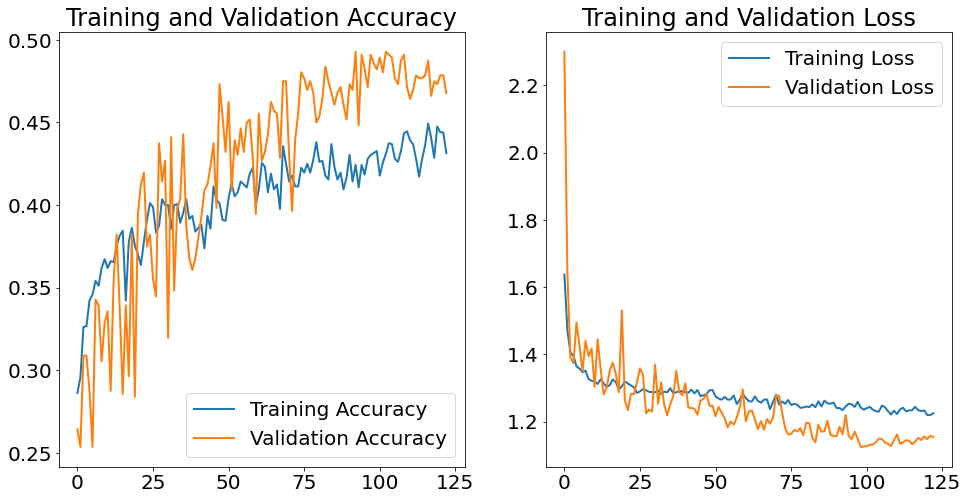

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',linewidth=2.0)
plt.plot(epochs_range, val_acc, label='Validation Accuracy',linewidth=2.0)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',linewidth=2.0)
plt.plot(epochs_range, val_loss, label='Validation Loss',linewidth=2.0)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/ShardDrives/My Drive/CSE382M/proj_model1/history.png", dpi=300)
plt.show()